In [1]:
import pickle
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import sys
import math

%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display

plt.rcParams["figure.figsize"] = (10, 6)

# Магия, чтобы модуль experimental_net импортировался заново при изменениях в нём.
%reload_ext autoreload
%aimport experimental_net
%autoreload 1

import experimental_net as nn

experimental_net reload


In [2]:
cifar_folder = 'data/cifar-10-batches-py'

labels_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 
    'frog', 'horse', 'ship', 'truck']
label_count = len(labels_names)
print(labels_names)

def load_cifar_batch(folder, file):
    with open(os.path.join(folder, file), 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    print(dict[b'batch_label'])
    return dict[b'data'], np.array(dict[b'labels'])

def load_cifar(folder):
    x_tr = list()
    y_tr = list()
    for i in range(1, 6):
        x, y = load_cifar_batch(folder, 'data_batch_' + str(i))
        x_tr.append(x)
        y_tr.append(y)
    x_tr = np.concatenate(x_tr)
    y_tr = np.concatenate(y_tr)
    x_te, y_te = load_cifar_batch(folder, 'test_batch')
    return x_tr, y_tr, x_te, y_te

x_tr, y_tr, x_te, y_te = load_cifar(cifar_folder)
print(x_tr.shape, y_tr.shape, x_te.shape, y_te.shape)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
b'training batch 1 of 5'
b'training batch 2 of 5'
b'training batch 3 of 5'
b'training batch 4 of 5'
b'training batch 5 of 5'
b'testing batch 1 of 1'
(50000, 3072) (50000,) (10000, 3072) (10000,)


In [3]:
def plot_image(x, y):
    plt.imshow(x.reshape(3, 32, 32).transpose(1, 2, 0) / 256)
    plt.title(labels_names[y])
    plt.axis('off')

def show_image(x, y):
    plot_image(x, y)
    plt.show()

def show_images(xs, ys):
    n = len(xs)
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plot_image(xs[i], ys[i])
    plt.show()

def show_train_images(pos):
    show_images(x_tr[pos:pos+5], y_tr[pos:pos+5])

silence = interact(show_train_images, 
        pos=widgets.BoundedIntText(min=0, max=49999, step=5, value=0, description='Range start:'))

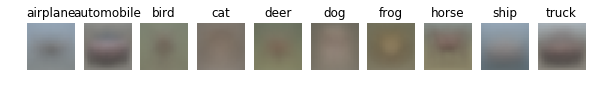

In [4]:
y_mean = range(10)
x_mean = [x_tr[y_tr == y].mean(axis=0) for y in y_mean]
show_images(x_mean, y_mean)

In [5]:
# Perform one hot encoding
y_tr_n = np.eye(label_count)[y_tr]
y_te_n = np.eye(label_count)[y_te]

print(y_tr_n.shape)
print(y_te_n.shape)

x_tr_n = x_tr / 256 - 0.5
x_te_n = x_te / 256 - 0.5

(50000, 10)
(10000, 10)


In [6]:
# ---------------------------------------------------------------------------------------------------

class BatchNorm(nn.Function):

    def __init__(self):
        self.sigma = None

    def calculate_y(self, x):
        y = x - np.mean(x, axis=0, keepdims=True)
        self.sigma = np.maximum(0.001, np.sqrt( np.std(y, axis=0, keepdims=True)))
        y = y / self.sigma
        return y

    def calculate_gx(self, x, y, gy):
        return gy * self.sigma



In [10]:
# Сетка

np.random.seed(5)

reg3 = 0.1

functions = [
    nn.Matrix(x_tr_n.shape[1], 100, sigma=1, reg3=reg3),
    nn.Bias(100, reg3=reg3),
    BatchNorm(),
    nn.Tanh(),

    nn.Matrix(100, 100, reg3=reg3),
    nn.Bias(100, reg3=reg3),
    BatchNorm(),
    nn.Tanh(),

    nn.Matrix(100, 100, reg3=reg3),
    nn.Bias(100, reg3=reg3),
    BatchNorm(),
    nn.Tanh(),

    nn.Matrix(100, label_count, reg3=reg3),
    nn.Bias(label_count, reg3=reg3),
    #nn.SoftMax(),
    #nn.EntropyLoss()
    nn.SvmLoss()
]

net = nn.build_sequence_net(functions)

In [8]:
output = widgets.Output()
output.layout.height = '380px'
#output.layout.height = '100px'
display(output)

def show_matrix_images(w):
    images = w.transpose() * 5000 + 128
    images = np.minimum(255, np.maximum(0, images))
    image_count = images.shape[0]
    column_count = 10
    image_count = min(image_count, 50)
    row_count = math.ceil(image_count / column_count)
    global output
    output.clear_output()
    with(output):
        for i in range(image_count):
            image = images[i]
            plt.subplot(row_count, column_count, i + 1)
            plt.imshow(image.reshape(3, 32, 32).transpose(1, 2, 0) / 256)
            plt.axis('off')
        plt.show()


In [12]:
def train_epoch(net, speed):
    loss_before = net.calculate_loss([x_tr_n], y_tr_n)
    
    batch_size = 1000
    train_len = x_tr_n.shape[0]
    for i in range(0, train_len // batch_size):
        batch_start = i * batch_size
        batch_end = min(train_len, batch_start + batch_size)
        x_batch = x_tr_n[batch_start:batch_end]
        y_batch = y_tr_n[batch_start:batch_end]

        loss = net.train([x_batch], y_batch, speed)

        sys.stdout.write('\rTrain. Batch: %d, loss %f' % (i, loss))
        sys.stdout.flush()

    loss_after = net.calculate_loss([x_tr_n], y_tr_n)
    sys.stdout.write('\rEpoch complete. Loss before: %f, after: %f, change: %f\n' 
        % (loss_before, loss_after, loss_after - loss_before))
    sys.stdout.flush()
    print('Accuracy tr:', net.calculate_accuracy([x_tr_n], y_tr_n))
    print('Accuracy te:', net.calculate_accuracy([x_te_n], y_te_n))

for i in range(5):
    train_epoch(net, 0.1)

    show_matrix_images(functions[0].w)


Epoch complete. Loss before: 5.024983, after: 4.984204, change: -0.040778
Accuracy tr: 0.33698
Accuracy te: 0.3339
Epoch complete. Loss before: 4.984204, after: 4.951167, change: -0.033038
Accuracy tr: 0.33984
Accuracy te: 0.3367
Epoch complete. Loss before: 4.951167, after: 4.923596, change: -0.027571
Accuracy tr: 0.34144
Accuracy te: 0.3373
Epoch complete. Loss before: 4.923596, after: 4.899864, change: -0.023732
Accuracy tr: 0.34356
Accuracy te: 0.3399
Epoch complete. Loss before: 4.899864, after: 4.878392, change: -0.021472
Accuracy tr: 0.3448
Accuracy te: 0.3402
